In [1]:
%pylab inline
#%load_ext autoreload
#%autoreload 2
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.insert(0, '..')
import tensorflow as tf
import tf_slim as slim
from graphgan.utils import get_3d_direction
from graphgan.layers import *
from graphgan.gradient_penalty import gradient_penaly
from graphgan.datasets import graph_input_fn
from astropy.table import Table, join
from functools import partial
from halotools_ia.correlation_functions  import ed_3d,ee_3d, ed_3d_one_two_halo_decomp
print(" Available: ",  (tf.config.list_physical_devices('GPU')))
from sklearn.preprocessing import RobustScaler


Populating the interactive namespace from numpy and matplotlib



 Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load the data

In [2]:
import pickle
from pandas import *
mb2 = Table.read('/hildafs/home/yjagvara/graphs4ia/MB2_subfind_z_1.0_small.hdf5' )
mb2 = mb2[log10(mb2['halos.m_star']*10**10)>9]
tng = pickle.load(  open('/hildafs/projects/phy200017p/yjagvara/some_data/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP.pkl', "rb" ) )

#tng = Table.from_pandas(DataFrame(tng))
tng = tng[tng['dm_mass']>0]
tng = tng[[log10(tng['dm_mass']*10**10)>9]]
tng = tng[[log10(tng['mass']*10**10)>9]]

/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/astropy/table/table.py:1145: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]
/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/numpy/ma/core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/hildafs/projects/phy200017p/yjagvara/conda_envs/test-tf2/lib/python3.8/site-packages/numpy/ma/core.py:3257: FutureWarning: Using a non-tuple sequence for multidimensional indexing is 

In [3]:
# hist(tng['tid_cv_x_0.1_1024']*tng['tid_cv_x_0.25_1024'] +
#     tng['tid_cv_y_0.1_1024']*tng['tid_cv_y_0.25_1024']+
#     tng['tid_cv_z_0.1_1024']*tng['tid_cv_z_0.25_1024']  ,100,alpha=0.5,density=True);

# hist(tng['tid_cv_x_0.1_1024']*tng['tid_cv_x_0.5_1024'] +
#     tng['tid_cv_y_0.1_1024']*tng['tid_cv_y_0.5_1024']+
#     tng['tid_cv_z_0.1_1024']*tng['tid_cv_z_0.5_1024']  ,100,alpha=0.5,density=True);
# hist(tng['tid_cv_x_0.1_1024']*tng['tid_cv_x_1_1024'] +
#     tng['tid_cv_y_0.1_1024']*tng['tid_cv_y_1_1024']+
#     tng['tid_cv_z_0.1_1024']*tng['tid_cv_z_1_1024']  ,100,alpha=0.5,density=True);

# hist(tng['tid_cv_x_0.1_1024']*tng['tid_cv_x_3_1024'] +
#     tng['tid_cv_y_0.1_1024']*tng['tid_cv_y_3_1024']+
#     tng['tid_cv_z_0.1_1024']*tng['tid_cv_z_3_1024']  ,100,alpha=0.5,density=True);


In [4]:
tng

gal_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z,tid_av_x_0.1_1024,tid_av_y_0.1_1024,tid_av_z_0.1_1024,tid_bv_x_0.1_1024,tid_bv_y_0.1_1024,tid_bv_z_0.1_1024,tid_cv_x_0.1_1024,tid_cv_y_0.1_1024,tid_cv_z_0.1_1024,tid_a_0.1_1024,tid_b_0.1_1024,tid_c_0.1_1024,tid_av_x_0.5_1024,tid_av_y_0.5_1024,tid_av_z_0.5_1024,tid_bv_x_0.5_1024,tid_bv_y_0.5_1024,tid_bv_z_0.5_1024,tid_cv_x_0.5_1024,tid_cv_y_0.5_1024,tid_cv_z_0.5_1024,tid_a_0.5_1024,tid_b_0.5_1024,tid_c_0.5_1024,tid_av_x_1.0_1024,tid_av_y_1.0_1024,tid_av_z_1.0_1024,tid_bv_x_1.0_1024,tid_bv_y_1.0_1024,tid_bv_z_1.0_1024,tid_cv_x_1.0_1024,tid_cv_y_1.0_1024,tid_cv_z_1.0_1024,tid_a_1.0_1024,tid_b_1.0_1024,tid_c_1.0_1024,tid_av_x_2.0_1024,tid_av_y_2.0_1024,tid_av_z_2.0_1024,tid_bv_x_2.0_1024,tid_bv_y_2.0_1024,tid_bv_z_2.0_1024,tid_cv_x_2.0_1024,tid_cv_y_2.0_1024,tid_cv_z_2.0_1024,tid_a_2.0_1024,tid_b_2.0_1024,tid_c_2.0_1024,mass,GroupID,tot_mass,dm_mass,central_bool,group_mass,group_x,group_y,group_z,gal_pos_x,gal_pos_y,gal_pos_z,dm_av_x,dm_av_y,dm_av_z,dm_bv_x,dm_bv_y,dm_bv_z,dm_cv_x,dm_cv_y,dm_cv_z,dm_a,dm_b,dm_c,mlp_av_x,mlp_av_y,mlp_av_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.24562844247483243,0.11233008826530698,0.09435347356932028,0.15057356009311798,-0.36432524666271543,0.9190183445639349,-0.6040801058750838,0.7019725376704176,0.37725559246020707,0.7825693762771655,0.611965416507098,0.11438312949234405,0.8275753855705261,0.5501617810833461,-0.11153932645318682,-0.4364806852752775,0.7555949692944677,0.4884269175204382,0.3529923768186143,-0.355525325415916,0.8654467776217399,1054.244087225318,991.9027130436707,668.0261137005616,-0.9183833599090576,0.33972494317589014,0.20287679547321114,0.33534699111399274,0.9403888675675559,-0.05666721544068841,-0.2100343464963115,0.015991896046057438,-0.9775632115381181,59.10935058615099,55.377614125575626,37.975054282341716,0.9371282458305359,0.1784244452709745,-0.29992566920893826,-0.2053100234179685,0.9768323454844315,-0.06038512316371721,0.2822029128212493,0.11816634946180396,0.9520494891811419,13.122050507836377,11.700347539646893,9.282237732126015,-0.8248880505561829,0.33217499988277654,0.4574051124728157,0.5063412900419841,0.7939398479662237,0.3365679958195495,-0.2513526714837356,0.5092340201363678,-0.8231054290148635,2.5250096232145673,2.341083724345102,1.7858375325765965,251.0163116455078,0.0,27477.935546875,23325.619140625,1.0,38878.03515625,849.0914306640625,26326.99609375,18306.93359375,0.8490914106369019,26.326995849609375,18.306934356689453,0.20913785733198287,-0.2376266091458571,0.9485752217175131,-0.0291868731156354,0.9680772186306577,0.24894703293283385,0.9774505015950008,0.07975019369363229,-0.19552601754628252,0.7422561814889702,0.380580342545896,0.2953753041796042,-0.5017646551132202,-0.3167201280593872,0.4968661665916443
1.0,0.08088470650058953,0.04497213832247513,0.03777383880658522,-0.9840750455762398,-0.006859759853817557,0.17762108086843106,0.07866214907516236,0.8792771126813137,0.46977018361927686,-0.15940066178344028,0.4762611707976621,-0.8647350612837673,-0.25285616517066956,-0.542943046543665,-0.8007974784346137,-0.0015899779481896464,-0.8274600252025045,0.5615223759228073,0.9675025711735737,-0.14325765215776112,-0.20836511193280413,340.0297044488053,304.0921077455601,251.82406385313607,-0.43189844489097595,-0.6954925306839556,-0.5742419895334245,-0.7

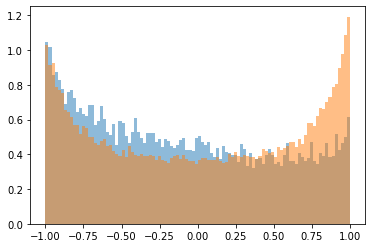

In [5]:
hist(tng['tid_cv_x_0.1_1024']*tng['dm_av_x'] +
    tng['tid_cv_y_0.1_1024']*tng['dm_av_y']+
    tng['tid_cv_z_0.1_1024']*tng['dm_av_z']  ,100,alpha=0.5,density=True);

hist(mb2['tid1000.c_x']*mb2['shapesDM.a3d_x'] +
    mb2['tid1000.c_y']*mb2['shapesDM.a3d_y'] +
    mb2['tid1000.c_z']*mb2['shapesDM.a3d_z']  ,100,alpha=0.5,density=True);



(0.0, 1.5)

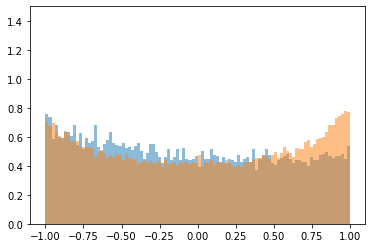

In [6]:
hist((tng['tid_cv_x_0.1_1024']*tng['av_x'] +
    tng['tid_cv_y_0.1_1024']*tng['av_y'] +
    tng['tid_cv_z_0.1_1024']*tng['av_z'])  ,100,alpha=0.5,density=True);

hist(mb2['tid1000.c_x']*mb2['shapesStar.a3d_x'] +
    mb2['tid1000.c_y']*mb2['shapesStar.a3d_y'] +
    mb2['tid1000.c_z']*mb2['shapesStar.a3d_z']  ,100,alpha=0.5,density=True);
ylim(0,1.5)

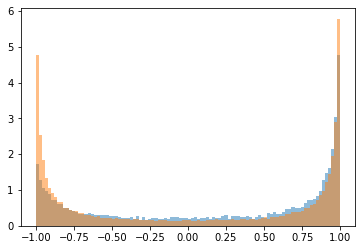

In [7]:
hist((tng['dm_av_x']*tng['av_x'] +
    tng['dm_av_y']*tng['av_y'] +
    tng['dm_av_z']*tng['av_z'])  ,100,alpha=0.5,density=True);

hist(mb2['shapesDM.a3d_x']*mb2['shapesStar.a3d_x'] +
    mb2['shapesDM.a3d_y']*mb2['shapesStar.a3d_y'] +
    mb2['shapesDM.a3d_z']*mb2['shapesStar.a3d_z']  ,100,alpha=0.5,density=True);

(array([0.31698822, 0.39854752, 0.4405884 , 0.4313394 , 0.44731494,
        0.47506192, 0.56418858, 0.62556826, 0.69367448, 0.60791109]),
 array([-9.998680e-01, -7.999153e-01, -5.999626e-01, -4.000099e-01,
        -2.000572e-01, -1.045000e-04,  1.998482e-01,  3.998009e-01,
         5.997536e-01,  7.997063e-01,  9.996590e-01]),
 <a list of 10 Patch objects>)

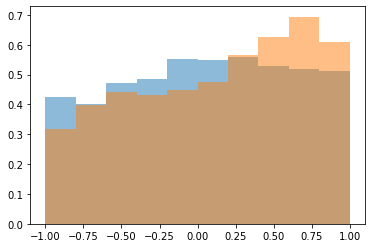

In [8]:
hist(tng['tid_bv_z_0.1_1024'] ,alpha=0.5 ,density=True)
hist(mb2['tid1000.b_z'][log10(mb2['halos.m_star']*10**10)>10.],alpha=0.5,density=True)

In [9]:
from sklearn.preprocessing import RobustScaler

# Reoriente all galaxies with respect to the tidal field
# Pre-processing the orientation of galaxies with respect to their host haloes and the tidal field

# Computes the size of groups
gids, idx, inv, counts  = np.unique(mb2['groups.groupId'],  return_index=True, return_inverse=True, return_counts=True)
mb2['group_size'] = counts[inv]

# Convert distances to Mpc
mb2['halos.x'] /= 1000.
mb2['halos.y'] /= 1000.
mb2['halos.z'] /= 1000.

mb2['groups.x'] /= 1000.
mb2['groups.y'] /= 1000.
mb2['groups.z'] /= 1000.

# Computes direction to the central
mb2['cen_x'] = mb2['groups.x'][idx][inv] - mb2['halos.x']
mb2['cen_y'] = mb2['groups.y'][idx][inv] - mb2['halos.y']
mb2['cen_z'] = mb2['groups.z'][idx][inv] - mb2['halos.z']
ncen = np.sqrt(mb2['cen_x']**2 + mb2['cen_y']**2 + mb2['cen_z']**2 ) 
mb2['cen_r'] = ncen

inds_cent = ncen == 0
ncen[ncen == 0] = 1
mb2['cen_x'] = mb2['cen_x']/ncen
mb2['cen_y'] = mb2['cen_y']/ncen
mb2['cen_z'] = mb2['cen_z']/ncen

# # First reorienting the tidal 
# a = (mb2['tid1000.c_x']*mb2['cen_x'] +
#      mb2['tid1000.c_y']*mb2['cen_y'] +
#      mb2['tid1000.c_z']*mb2['cen_z'])

# # According to the sign, decide to reverse the orientation of
# flip_a = ones_like(a)
# flip_a[where(a < 0)] *= -1.0
# mb2['tid1000.c_x'] *= flip_a
# mb2['tid1000.c_y'] *= flip_a
# mb2['tid1000.c_z'] *= flip_a
# mb2['tid1000.b_x'] *= flip_a
# mb2['tid1000.b_y'] *= flip_a
# mb2['tid1000.b_z'] *= flip_a

# Computing angle with respect to the tidal field,
# adjusting the axes to have the same orientation
aTid = (mb2['shapesDM.a3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.a3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.a3d_z']*mb2['tid1000.c_z'])
bTid = (mb2['shapesDM.b3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.b3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.b3d_z']*mb2['tid1000.c_z'])
cTid = (mb2['shapesDM.c3d_x']*mb2['tid1000.c_x'] +
        mb2['shapesDM.c3d_y']*mb2['tid1000.c_y'] +
        mb2['shapesDM.c3d_z']*mb2['tid1000.c_z'])
caTid = (mb2['shapesDM.c3d_x']*mb2['tid1000.a_x'] +
         mb2['shapesDM.c3d_y']*mb2['tid1000.a_y'] +
         mb2['shapesDM.c3d_z']*mb2['tid1000.a_z'])

# According to the sign, decide to reverse the orientation of
# the dark matter halo by rotating around b or c
flip_a = ones_like(aTid)
flip_a[where(aTid < 0)] *= -1.0
flip_c = ones_like(cTid)
flip_c[where(caTid < 0)] *= -1.0
flip_b = ones_like(bTid)
flip_b = flip_a * flip_c

# Apply rotation around c, thus preserving the sign of c
aTid *= flip_a
bTid *= flip_b
cTid *= flip_c

# Update the DM halo orientation
mb2['shapesDM.a3d_x'] *= flip_a
mb2['shapesDM.a3d_y'] *= flip_a
mb2['shapesDM.a3d_z'] *= flip_a
mb2['shapesDM.b3d_x'] *= flip_b
mb2['shapesDM.b3d_y'] *= flip_b
mb2['shapesDM.b3d_z'] *= flip_b
mb2['shapesDM.c3d_x'] *= flip_c
mb2['shapesDM.c3d_y'] *= flip_c
mb2['shapesDM.c3d_z'] *= flip_c

# Compute misalignment of stellar component in same rotated frame
a = (mb2['shapesDM.a3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.a3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.a3d_z']*mb2['shapesStar.a3d_z'])
b = (mb2['shapesDM.b3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.b3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.b3d_z']*mb2['shapesStar.a3d_z'])
c = (mb2['shapesDM.c3d_x']*mb2['shapesStar.a3d_x'] +
     mb2['shapesDM.c3d_y']*mb2['shapesStar.a3d_y'] +
     mb2['shapesDM.c3d_z']*mb2['shapesStar.a3d_z'])
cc = (mb2['shapesDM.c3d_x']*mb2['shapesStar.c3d_x'] +
      mb2['shapesDM.c3d_y']*mb2['shapesStar.c3d_y'] +
      mb2['shapesDM.c3d_z']*mb2['shapesStar.c3d_z'])

# Apply rotation to the Stellar shape frame to match DM frame
flip_a_stel = ones_like(a)
flip_a_stel[where(a < 0)] *= -1.0
flip_c_stel = ones_like(cc)
flip_c_stel[where(cc < 0)] *= -1.0
flip_b_stel = flip_a_stel * flip_c_stel

# Rotation around c, leaving c unchanged
# Rotation around a, leaving a unchanged
a *= flip_a_stel
b *= flip_b_stel
c *= flip_c_stel

# Update the Stellar halo orientation
mb2['shapesStar.a3d_x'] *= flip_a_stel
mb2['shapesStar.a3d_y'] *= flip_a_stel
mb2['shapesStar.a3d_z'] *= flip_a_stel
mb2['shapesStar.b3d_x'] *= flip_b_stel
mb2['shapesStar.b3d_y'] *= flip_b_stel
mb2['shapesStar.b3d_z'] *= flip_b_stel
mb2['shapesStar.c3d_x'] *= flip_c_stel
mb2['shapesStar.c3d_y'] *= flip_c_stel
mb2['shapesStar.c3d_z'] *= flip_c_stel

# For the centrals, let's use the direction of the dark matter halo, why not
# mb2['cen_x'][inds_cent] = mb2['shapesDM.a3d_x'][inds_cent]
# mb2['cen_y'][inds_cent] = mb2['shapesDM.a3d_y'][inds_cent]
# mb2['cen_z'][inds_cent] = mb2['shapesDM.a3d_z'][inds_cent]

# Make the orientation of the central directoin match the DM orientation
# a = (mb2['shapesDM.a3d_x']*mb2['cen_x'] +
#      mb2['shapesDM.a3d_y']*mb2['cen_y'] +
#      mb2['shapesDM.a3d_z']*mb2['cen_z'])

# # According to the sign, decide to reverse the orientation of
# flip_a = ones_like(a)
# flip_a[where(a < 0)] *= -1.0

# mb2['shapesDM.a3d_x'] *= flip_a
# mb2['shapesDM.a3d_y'] *= flip_a
# mb2['shapesDM.a3d_z'] *= flip_a

# Doing some preprocessing
mb2['halos.mass'] = log10(mb2['halos.mass'])
mb2['groups.mass'] = log10(mb2['groups.mass']*1e10+1)
mb2['halos.m_star'] = log10(mb2['halos.m_star']*1e10+1)
mb2['halos.m_dm'] = log10(mb2['halos.m_dm']*1e10+1)
m = (mb2['halos.m_star'] > 8.5) & (mb2['halos.mass'] > 10) & (mb2['group_size'] > 1)& (mb2['group_size'] < 500)
mb2_cat=mb2[m]

(array([2124., 2086., 2363., 1895., 1304., 1789., 1305., 1422., 1284.,
        1885.]),
 array([5.53445244e+00, 7.50370210e+03, 1.50018697e+04, 2.25000374e+04,
        2.99982050e+04, 3.74963727e+04, 4.49945403e+04, 5.24927080e+04,
        5.99908756e+04, 6.74890433e+04, 7.49872109e+04]),
 <a list of 10 Patch objects>)

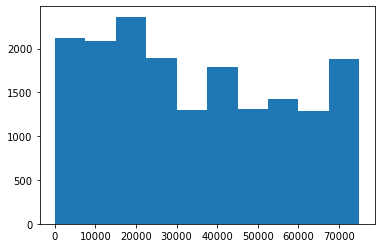

In [10]:
hist(tng['group_x'])

In [11]:


# Reoriente all galaxies with respect to the tidal field
# Pre-processing the orientation of galaxies with respect to their host haloes and the tidal field

# Computes the size of groups
gids, idx, inv, counts  = np.unique(tng['GroupID'],  return_index=True, return_inverse=True, return_counts=True)
tng['group_size'] = counts[inv]

# Convert distances to Mpc
# tng['gal_pos_x'] /= 1000.
# tng['gal_pos_y'] /= 1000.
# tng['gal_pos_z'] /= 1000.

tng['group_x'] /= 1000.
tng['group_y'] /= 1000.
tng['group_z'] /= 1000.

# Computes direction to the central
tng['cen_x'] = tng['group_x'][idx][inv] - tng['gal_pos_x']
tng['cen_y'] = tng['group_y'][idx][inv] - tng['gal_pos_y']
tng['cen_z'] = tng['group_z'][idx][inv] - tng['gal_pos_z']
ncen = np.sqrt(tng['cen_x']**2 + tng['cen_y']**2 + tng['cen_z']**2 ) 
tng['cen_r'] = ncen

inds_cent = ncen == 0
ncen[ncen == 0] = 1
tng['cen_x'] = tng['cen_x']/ncen
tng['cen_y'] = tng['cen_y']/ncen
tng['cen_z'] = tng['cen_z']/ncen

# # First reorienting the tidal 
a = (tng['tid_av_x_0.1_1024']*tng['cen_x'] +
     tng['tid_av_y_0.1_1024']*tng['cen_y'] +
     tng['tid_av_z_0.1_1024']*tng['cen_z'])

# According to the sign, decide to reverse the orientation of
flip_a = ones_like(a)
flip_a[where(a < 0)] *= -1.0
tng['tid_av_x_0.1_1024'] *= flip_a
tng['tid_av_y_0.1_1024'] *= flip_a
tng['tid_av_z_0.1_1024'] *= flip_a
tng['tid_bv_x_0.1_1024'] *= flip_a
tng['tid_bv_y_0.1_1024'] *= flip_a
tng['tid_bv_z_0.1_1024'] *= flip_a

# Computing angle with respect to the tidal field,
# adjusting the axes to have the same orientation
aTid = (tng['dm_av_x']*tng['tid_cv_x_0.1_1024'] +
        tng['dm_av_y']*tng['tid_cv_y_0.1_1024'] +
        tng['dm_av_z']*tng['tid_cv_z_0.1_1024'])
bTid = (tng['dm_bv_x']*tng['tid_cv_x_0.1_1024'] +
        tng['dm_bv_y']*tng['tid_cv_y_0.1_1024'] +
        tng['dm_bv_z']*tng['tid_cv_z_0.1_1024'])
cTid = (tng['dm_cv_x']*tng['tid_cv_x_0.1_1024'] +
        tng['dm_cv_y']*tng['tid_cv_y_0.1_1024'] +
        tng['dm_cv_z']*tng['tid_cv_z_0.1_1024'])
caTid = (tng['dm_cv_x']*tng['tid_av_x_0.1_1024'] +
         tng['dm_cv_y']*tng['tid_av_y_0.1_1024'] +
         tng['dm_cv_z']*tng['tid_av_z_0.1_1024'])

# According to the sign, decide to reverse the orientation of
# the dark matter halo by rotating around b or c
flip_a = ones_like(aTid)
flip_a[where(aTid < 0)] *= -1.0
flip_c = ones_like(cTid)
flip_c[where(caTid < 0)] *= -1.0
flip_b = ones_like(bTid)
flip_b = flip_a * flip_c

# Apply rotation around c, thus preserving the sign of c
aTid *= flip_a
bTid *= flip_b
cTid *= flip_c

# Update the DM halo orientation
tng['dm_av_x'] *= flip_a
tng['dm_av_y'] *= flip_a
tng['dm_av_z'] *= flip_a
tng['dm_bv_x'] *= flip_b
tng['dm_bv_y'] *= flip_b
tng['dm_bv_z'] *= flip_b
tng['dm_cv_x'] *= flip_c
tng['dm_cv_y'] *= flip_c
tng['dm_cv_z'] *= flip_c

# Compute misalignment of stellar component in same rotated frame
a = (tng['dm_av_x']*tng['av_x'] +
     tng['dm_av_y']*tng['av_y'] +
     tng['dm_av_z']*tng['av_z'])
b = (tng['dm_bv_x']*tng['av_x'] +
     tng['dm_bv_y']*tng['av_y'] +
     tng['dm_bv_z']*tng['av_z'])
c = (tng['dm_cv_x']*tng['av_x'] +
     tng['dm_cv_y']*tng['av_y'] +
     tng['dm_cv_z']*tng['av_z'])
cc = (tng['dm_cv_x']*tng['cv_x'] +
      tng['dm_cv_y']*tng['cv_y'] +
      tng['dm_cv_z']*tng['cv_z'])

# Apply rotation to the Stellar shape frame to match DM frame
flip_a_stel = ones_like(a)
flip_a_stel[where(a < 0)] *= -1.0
flip_c_stel = ones_like(cc)
flip_c_stel[where(cc < 0)] *= -1.0
flip_b_stel = flip_a_stel * flip_c_stel

# Rotation around c, leaving c unchanged
# Rotation around a, leaving a unchanged
a *= flip_a_stel
b *= flip_b_stel
c *= flip_c_stel

# Update the Stellar halo orientation
tng['av_x'] *= flip_a_stel
tng['av_y'] *= flip_a_stel
tng['av_z'] *= flip_a_stel
tng['bv_x'] *= flip_b_stel
tng['bv_y'] *= flip_b_stel
tng['bv_z'] *= flip_b_stel
tng['cv_x'] *= flip_c_stel
tng['cv_y'] *= flip_c_stel
tng['cv_z'] *= flip_c_stel

In [12]:


# For the centrals, let's use the direction of the dark matter halo, why not
# tng['cen_x'][inds_cent] = tng['dm_av_x'][inds_cent]
# tng['cen_y'][inds_cent] = tng['dm_av_y'][inds_cent]
# tng['cen_z'][inds_cent] = tng['dm_av_z'][inds_cent]

# Make the orientation of the central directoin match the DM orientation
# a = (tng['dm_av_x']*tng['cen_x'] +
#      tng['dm_av_y']*tng['cen_y'] +
#      tng['dm_av_z']*tng['cen_z'])

# # According to the sign, decide to reverse the orientation of
# flip_a = ones_like(a)
# flip_a[where(a < 0)] *= -1.0

# tng['dm_av_x'] *= flip_a
# tng['dm_av_y'] *= flip_a
# tng['dm_av_z'] *= flip_a

# Doing some preprocessing
tng['tot_mass'] = log10(tng['tot_mass']*1e10)
tng['group_mass'] = log10(tng['group_mass']*1e10)
tng['mass'] = log10(tng['mass']*1e10)#*1e10+1)
tng['dm_mass'] = log10(tng['dm_mass']*1e10)#*1e10+1)

# # Normalisation of the tidal field, (robust protects from outliers)
# tng['normed_eigv1'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid1000.eigv1'].reshape(-1, 1)))
# tng['normed_eigv2'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid1000.eigv2'].reshape(-1, 1)))
# tng['normed_eigv3'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid1000.eigv3'].reshape(-1, 1)))
# tng['normed_eigv1_5'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid500.eigv1'].reshape(-1, 1)))
# tng['normed_eigv2_5'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid500.eigv2'].reshape(-1, 1)))
# tng['normed_eigv3_5'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid500.eigv3'].reshape(-1, 1)))
# tng['normed_eigv1_10'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid10000.eigv1'].reshape(-1, 1)))
# tng['normed_eigv2_10'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid10000.eigv2'].reshape(-1, 1)))
# tng['normed_eigv3_10'] = squeeze(RobustScaler(with_centering=False).fit_transform(tng['tid10000.eigv3'].reshape(-1, 1)))

In [13]:
tng['dm_mass'] 

14.367833180212248
13.50298481399793
12.856235701293752
12.492075007318201
12.48691572674364
12.451609934560004
12.268136164748892
12.095911876887975
12.014287134223032
12.062344157286425
11.932913682607655


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.296e+04]),
 array([ 0.        ,  0.37162108,  0.74324217,  1.11486325,  1.48648434,
         1.85810542,  2.22972651,  2.60134759,  2.97296868,  3.34458976,
         3.71621085,  4.08783193,  4.45945302,  4.8310741 ,  5.20269519,
         5.57431627,  5.94593736,  6.31755844,  6.68917953,  7.06080061,
         7.4324217 ,  7.80404278,  8.17566386,  8.54728495,  8.91890603,
         9.29052712,  9.6621482 , 10.03376929, 10.40539037, 10.77701146,
        11.14863254]),
 <a list of 30 Patch objects>)

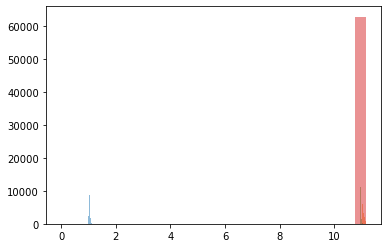

In [14]:
nbin=30
plt.hist(log10(mb2['halos.mass']),alpha=0.5,bins=nbin) 
plt.hist(log10(mb2['groups.mass']*1e10+1),alpha=0.5,bins=nbin)
plt.hist(log10(mb2['halos.m_star']*1e10+1),alpha=0.5,bins=nbin)
plt.hist(log10(mb2['halos.m_dm']*1e10+1),alpha=0.5,bins=nbin)

(array([  42.,   71.,   98.,  177.,  264.,  367.,  486.,  658.,  821.,
        1089., 1619., 2794., 2732., 2040., 1358.,  953.,  635.,  425.,
         262.,  199.,  128.,   82.,   61.,   32.,   21.,   23.,    7.,
           3.,    7.,    3.]),
 array([ 9.00045019,  9.17961486,  9.35877953,  9.5379442 ,  9.71710887,
         9.89627354, 10.07543821, 10.25460288, 10.43376755, 10.61293222,
        10.7920969 , 10.97126157, 11.15042624, 11.32959091, 11.50875558,
        11.68792025, 11.86708492, 12.04624959, 12.22541426, 12.40457893,
        12.5837436 , 12.76290827, 12.94207294, 13.12123761, 13.30040228,
        13.47956695, 13.65873163, 13.8378963 , 14.01706097, 14.19622564,
        14.37539031]),
 <a list of 30 Patch objects>)

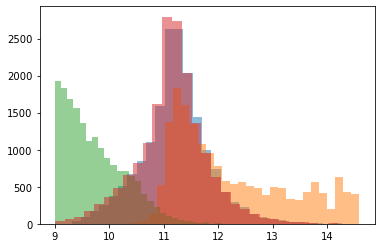

In [15]:
nbin=30
plt.hist(tng['tot_mass'],alpha=0.5,bins=nbin) 
plt.hist(tng['group_mass'],alpha=0.5,bins=nbin)
plt.hist(tng['mass'],alpha=0.5,bins=nbin)
plt.hist(tng['dm_mass'],alpha=0.5,bins=nbin)

In [16]:
# Apply cuts on the training set
m = (tng['mass'] > 8.5) & (tng['tot_mass'] > 9)# & (tng['group_size'] > 0)& (tng['group_size'] < 500)
print(len(m),sum(m))

17457 17457


(array([2124., 2086., 2363., 1895., 1304., 1789., 1305., 1422., 1284.,
        1885.]),
 array([5.53445244e-03, 7.50370210e+00, 1.50018697e+01, 2.25000374e+01,
        2.99982050e+01, 3.74963727e+01, 4.49945403e+01, 5.24927080e+01,
        5.99908756e+01, 6.74890433e+01, 7.49872109e+01]),
 <a list of 10 Patch objects>)

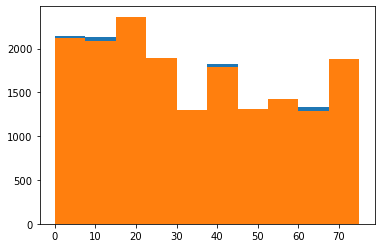

In [17]:
hist(tng['gal_pos_x'])
hist(tng['group_x'])

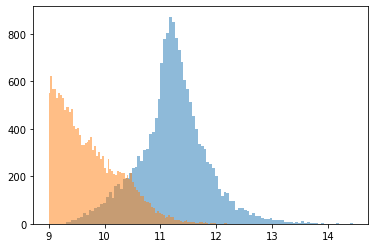

In [18]:
hist(tng['tot_mass'][m],100,alpha=0.5);
hist(tng['mass'][m],100,alpha=0.5);

In [19]:
catalog = tng[m]
len(catalog['tot_mass'])

17457

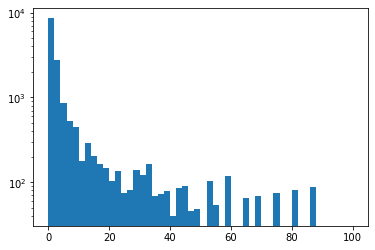

In [20]:
hist(catalog['group_size'],50,range=[0,100]);
yscale('log')

In [21]:
catalog['dm_mass_scaled'] = clip(RobustScaler().fit_transform(catalog['dm_mass'].reshape((-1,1))),-5,5).squeeze()
catalog['mass_scaled'] = clip(RobustScaler().fit_transform(catalog['mass'].reshape((-1,1))),-5,5).squeeze()
catalog['group_mass_scaled'] = clip(RobustScaler().fit_transform(catalog['group_mass'].reshape((-1,1))),-5,5).squeeze()

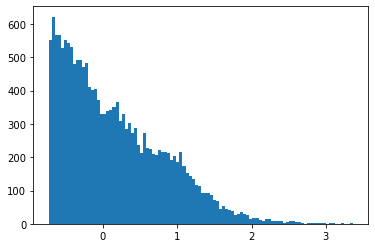

In [22]:
hist(catalog['mass_scaled'],100);

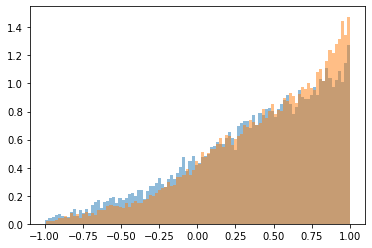

In [23]:
hist(catalog['tid_cv_x_0.1_1024']*catalog['av_x'] +
    catalog['tid_cv_y_0.1_1024']*catalog['av_y'] +
    catalog['tid_cv_z_0.1_1024']*catalog['av_z']  ,100,alpha=0.5,density=True);

hist(mb2_cat['tid1000.c_x']*mb2_cat['shapesStar.a3d_x'] +
    mb2_cat['tid1000.c_y']*mb2_cat['shapesStar.a3d_y'] +
    mb2_cat['tid1000.c_z']*mb2_cat['shapesStar.a3d_z']  ,100,alpha=0.5,density=True);

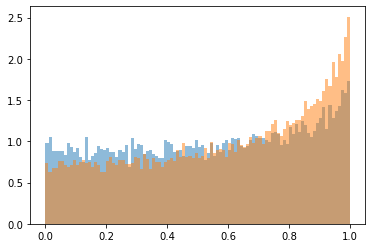

In [24]:
hist((catalog['tid_cv_x_0.1_1024']*catalog['dm_av_x'] +
    catalog['tid_cv_y_0.1_1024']*catalog['dm_av_y'] +
    catalog['tid_cv_z_0.1_1024']*catalog['dm_av_z'] ) ,100,alpha=0.5,density=True);

# #hist(abs(tng['tid_cv_x']*tng['dm_av_x'] +
#     tng['tid_cv_y']*tng['dm_av_y'] +
#     tng['tid_cv_z']*tng['dm_av_z'] ) ,100,alpha=0.5,density=True);

hist(mb2_cat['tid1000.c_x']*mb2_cat['shapesDM.a3d_x'] +
    mb2_cat['tid1000.c_y']*mb2_cat['shapesDM.a3d_y'] +
    mb2_cat['tid1000.c_z']*mb2_cat['shapesDM.a3d_z']  ,100,alpha=0.5,density=True);

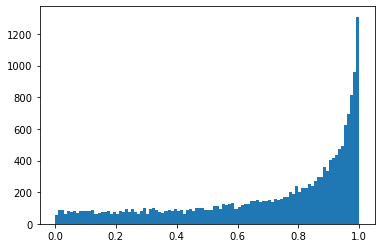

In [25]:
hist(catalog['dm_av_x']*catalog['av_x'] +
     catalog['dm_av_y']*catalog['av_y'] +
     catalog['dm_av_z']*catalog['av_z']  ,100);

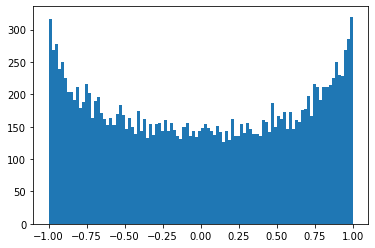

In [26]:
hist(catalog['cen_x']*catalog['av_x'] +
     catalog['cen_y']*catalog['av_y'] +
     catalog['cen_z']*catalog['av_z']  ,100);

In [27]:
catalog


gal_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z,tid_av_x_0.1_1024,tid_av_y_0.1_1024,tid_av_z_0.1_1024,tid_bv_x_0.1_1024,tid_bv_y_0.1_1024,tid_bv_z_0.1_1024,tid_cv_x_0.1_1024,tid_cv_y_0.1_1024,tid_cv_z_0.1_1024,tid_a_0.1_1024,tid_b_0.1_1024,tid_c_0.1_1024,tid_av_x_0.5_1024,tid_av_y_0.5_1024,tid_av_z_0.5_1024,tid_bv_x_0.5_1024,tid_bv_y_0.5_1024,tid_bv_z_0.5_1024,tid_cv_x_0.5_1024,tid_cv_y_0.5_1024,tid_cv_z_0.5_1024,tid_a_0.5_1024,tid_b_0.5_1024,tid_c_0.5_1024,tid_av_x_1.0_1024,tid_av_y_1.0_1024,tid_av_z_1.0_1024,tid_bv_x_1.0_1024,tid_bv_y_1.0_1024,tid_bv_z_1.0_1024,tid_cv_x_1.0_1024,tid_cv_y_1.0_1024,tid_cv_z_1.0_1024,tid_a_1.0_1024,tid_b_1.0_1024,tid_c_1.0_1024,tid_av_x_2.0_1024,tid_av_y_2.0_1024,tid_av_z_2.0_1024,tid_bv_x_2.0_1024,tid_bv_y_2.0_1024,tid_bv_z_2.0_1024,tid_cv_x_2.0_1024,tid_cv_y_2.0_1024,tid_cv_z_2.0_1024,tid_a_2.0_1024,tid_b_2.0_1024,tid_c_2.0_1024,mass,GroupID,tot_mass,dm_mass,central_bool,group_mass,group_x,group_y,group_z,gal_pos_x,gal_pos_y,gal_pos_z,dm_av_x,dm_av_y,dm_av_z,dm_bv_x,dm_bv_y,dm_bv_z,dm_cv_x,dm_cv_y,dm_cv_z,dm_a,dm_b,dm_c,mlp_av_x,mlp_av_y,mlp_av_z,group_size,cen_x,cen_y,cen_z,cen_r,dm_mass_scaled,mass_scaled,group_mass_scaled
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
0.0,0.24562844247483243,0.11233008826530698,0.09435347356932028,0.15057356009311798,-0.36432524666271543,0.9190183445639349,-0.6040801058750838,0.7019725376704176,0.37725559246020707,0.7825693762771655,0.611965416507098,0.11438312949234405,0.8275753855705261,0.5501617810833461,-0.11153932645318682,-0.4364806852752775,0.7555949692944677,0.4884269175204382,0.3529923768186143,-0.355525325415916,0.8654467776217399,1054.244087225318,991.9027130436707,668.0261137005616,-0.9183833599090576,0.33972494317589014,0.20287679547321114,0.33534699111399274,0.9403888675675559,-0.05666721544068841,-0.2100343464963115,0.015991896046057438,-0.9775632115381181,59.10935058615099,55.377614125575626,37.975054282341716,0.9371282458305359,0.1784244452709745,-0.29992566920893826,-0.2053100234179685,0.9768323454844315,-0.06038512316371721,0.2822029128212493,0.11816634946180396,0.9520494891811419,13.122050507836377,11.700347539646893,9.282237732126015,-0.8248880505561829,0.33217499988277654,0.4574051124728157,0.5063412900419841,0.7939398479662237,0.3365679958195495,-0.2513526714837356,0.5092340201363678,-0.8231054290148635,2.5250096232145673,2.341083724345102,1.7858375325765965,12.3997019439012,0.0,14.4389841005025,14.367833180212248,1.0,14.589704308148246,0.8490914306640625,26.32699609375,18.30693359375,0.8490914106369019,26.326995849609375,18.306934356689453,0.20913785733198287,-0.2376266091458571,0.9485752217175131,-0.0291868731156354,0.9680772186306577,0.24894703293283385,0.9774505015950008,0.07975019369363229,-0.19552601754628252,0.7422561814889702,0.380580342545896,0.2953753041796042,-0.5017646551132202,-0.3167201280593872,0.4968661665916443,227,0.02499332387213742,0.3046805214843022,-0.9521266268673911,8.013004072217826e-07,4.878295137797482,3.3631838415394504,1.5982613914386061
1.0,0.08088470650058953,0.04497213832247513,0.03777383880658522,0.9840750455762398,0.006859759853817557,-0.17762108086843106,0.07866214907516236,0.8792771126813137,0.46977018361927686,0.15940066178344028,-0.4762611707976621,0.8647350612837673,0.252856165170

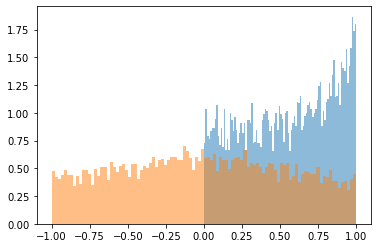

In [28]:
m = catalog['central_bool'] == 0
hist((catalog['tid_cv_x_0.1_1024']*catalog['dm_av_x'] +catalog['dm_av_y']*catalog['tid_cv_y_0.1_1024'] +  catalog['dm_av_z']*catalog['tid_cv_z_0.1_1024'])[m],100, alpha=0.5,density=True);
m = catalog['central_bool'] == 0
hist((catalog['tid_av_x_0.1_1024']*catalog['dm_av_x'] +catalog['dm_av_y']*catalog['tid_av_y_0.1_1024'] +  catalog['dm_av_z']*catalog['tid_av_z_0.1_1024'])[m],100, alpha=0.5,density=True);



In [29]:
catalog['tid_a_0.1_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_0.1_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_0.1_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_0.1_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_0.1_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_0.1_1024'].reshape((-1,1))),-5,5).squeeze()

In [30]:
catalog['tid_a_0.25_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_0.25_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_0.25_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_0.25_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_0.25_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_0.25_1024'].reshape((-1,1))),-5,5).squeeze()

KeyError: 'tid_a_0.25_1024'

In [47]:
catalog['tid_a_0.5_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_0.5_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_0.5_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_0.5_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_0.5_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_0.5_1024'].reshape((-1,1))),-5,5).squeeze()

In [50]:
catalog['tid_a_1.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_1.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_1.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_1.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_1.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_1.0_1024'].reshape((-1,1))),-5,5).squeeze()

In [53]:
catalog['tid_a_2.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_a_2.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_b_2.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_b_2.0_1024'].reshape((-1,1))),-5,5).squeeze()
catalog['tid_c_2.0_1024_scaled'] = clip(RobustScaler().fit_transform(catalog['tid_c_2.0_1024'].reshape((-1,1))),-5,5).squeeze()

In [54]:
catalog['tid_av_x_0.1_1024_neg'] = -catalog['tid_av_x_0.1_1024']
catalog['tid_av_y_0.1_1024_neg'] = -catalog['tid_av_y_0.1_1024']
catalog['tid_av_z_0.1_1024_neg'] = -catalog['tid_av_z_0.1_1024']
catalog['tid_bv_x_0.1_1024_neg'] = -catalog['tid_bv_x_0.1_1024']
catalog['tid_bv_y_0.1_1024_neg'] = -catalog['tid_bv_y_0.1_1024']
catalog['tid_bv_z_0.1_1024_neg'] = -catalog['tid_bv_z_0.1_1024']
catalog['tid_cv_x_0.1_1024_neg'] = -catalog['tid_cv_x_0.1_1024']
catalog['tid_cv_y_0.1_1024_neg'] = -catalog['tid_cv_y_0.1_1024']
catalog['tid_cv_z_0.1_1024_neg'] = -catalog['tid_cv_z_0.1_1024']

In [ ]:
catalog['tid_av_x_0.25_1024_neg'] = -catalog['tid_av_x_0.25_1024']
catalog['tid_av_y_0.25_1024_neg'] = -catalog['tid_av_y_0.25_1024']
catalog['tid_av_z_0.25_1024_neg'] = -catalog['tid_av_z_0.25_1024']
catalog['tid_bv_x_0.25_1024_neg'] = -catalog['tid_bv_x_0.25_1024']
catalog['tid_bv_y_0.25_1024_neg'] = -catalog['tid_bv_y_0.25_1024']
catalog['tid_bv_z_0.25_1024_neg'] = -catalog['tid_bv_z_0.25_1024']
catalog['tid_cv_x_0.25_1024_neg'] = -catalog['tid_cv_x_0.25_1024']
catalog['tid_cv_y_0.25_1024_neg'] = -catalog['tid_cv_y_0.25_1024']
catalog['tid_cv_z_0.25_1024_neg'] = -catalog['tid_cv_z_0.25_1024']

In [55]:
catalog['tid_av_x_0.5_1024_neg'] = -catalog['tid_av_x_0.5_1024']
catalog['tid_av_y_0.5_1024_neg'] = -catalog['tid_av_y_0.5_1024']
catalog['tid_av_z_0.5_1024_neg'] = -catalog['tid_av_z_0.5_1024']
catalog['tid_bv_x_0.5_1024_neg'] = -catalog['tid_bv_x_0.5_1024']
catalog['tid_bv_y_0.5_1024_neg'] = -catalog['tid_bv_y_0.5_1024']
catalog['tid_bv_z_0.5_1024_neg'] = -catalog['tid_bv_z_0.5_1024']
catalog['tid_cv_x_0.5_1024_neg'] = -catalog['tid_cv_x_0.5_1024']
catalog['tid_cv_y_0.5_1024_neg'] = -catalog['tid_cv_y_0.5_1024']
catalog['tid_cv_z_0.5_1024_neg'] = -catalog['tid_cv_z_0.5_1024']

In [56]:
catalog['tid_av_x_1.0_1024_neg'] = -catalog['tid_av_x_1.0_1024']
catalog['tid_av_y_1.0_1024_neg'] = -catalog['tid_av_y_1.0_1024']
catalog['tid_av_z_1.0_1024_neg'] = -catalog['tid_av_z_1.0_1024']
catalog['tid_bv_x_1.0_1024_neg'] = -catalog['tid_bv_x_1.0_1024']
catalog['tid_bv_y_1.0_1024_neg'] = -catalog['tid_bv_y_1.0_1024']
catalog['tid_bv_z_1.0_1024_neg'] = -catalog['tid_bv_z_1.0_1024']
catalog['tid_cv_x_1.0_1024_neg'] = -catalog['tid_cv_x_1.0_1024']
catalog['tid_cv_y_1.0_1024_neg'] = -catalog['tid_cv_y_1.0_1024']
catalog['tid_cv_z_1.0_1024_neg'] = -catalog['tid_cv_z_1.0_1024']

In [57]:
catalog['tid_av_x_2.0_1024_neg'] = -catalog['tid_av_x_2.0_1024']
catalog['tid_av_y_2.0_1024_neg'] = -catalog['tid_av_y_2.0_1024']
catalog['tid_av_z_2.0_1024_neg'] = -catalog['tid_av_z_2.0_1024']
catalog['tid_bv_x_2.0_1024_neg'] = -catalog['tid_bv_x_2.0_1024']
catalog['tid_bv_y_2.0_1024_neg'] = -catalog['tid_bv_y_2.0_1024']
catalog['tid_bv_z_2.0_1024_neg'] = -catalog['tid_bv_z_2.0_1024']
catalog['tid_cv_x_2.0_1024_neg'] = -catalog['tid_cv_x_2.0_1024']
catalog['tid_cv_y_2.0_1024_neg'] = -catalog['tid_cv_y_2.0_1024']
catalog['tid_cv_z_2.0_1024_neg'] = -catalog['tid_cv_z_2.0_1024']

tng = tng[tng['central_bool']==1]

## Define network

In [58]:
weighting='exp'
directions = get_3d_direction()
filter_size=directions.shape[-1]

# Define generator function
def conditional_generator_fn(inputs, 
                             is_training=True,
                             reuse=None,
                             scope='Generator',
                             fused_batch_norm=False):

    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = inputs
    # W_i matrices define the sprase matrix to construct adjecency
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    # Computes 3D adjacency matrix
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, radial_scale=0.4,
                           learn_scale=False)

    # Input level, transforming all inputs features into a single channel
    # First we mix the inputs
    net = graph_conv2(tf.concat([noise, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=128,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    net = graph_conv2(net, mr, num_outputs=64,  activation_fn=tf.nn.leaky_relu)
    net = slim.batch_norm(net)
    
    # Let's constrain the output to lie on the sphere, predicting major axis of the galaxy (unit vector)
    net_a3d = graph_conv2(net, mr, 3, activation_fn=None, one_hop=False)
    net_a3d = tf.nn.l2_normalize(net_a3d, axis=-1)
    
    # Assemble output, 
    out_net = tf.concat([net_a3d], axis=1)

    return out_net

def conditional_discriminator_fn(y, conditioning):
    """
    Discriminator network that can tell if the galaxies are correctly aligned
    args:
    y: alignment signal
    conditioning: tuple (adj, idn, x_spatial, pool, x, noise)
    """
    W0, W1, W2, pm0, pm1, pm2, xsp, X, noise = conditioning
    #pm_i are the pooling matrices, also sparse
    
    adj = tf.SparseTensor(tf.cast(W0, tf.int64),W1,W2)
    pool = tf.SparseTensor(tf.cast(pm0, tf.int64), pm1, pm2)
    
    # Computes 3D adjacency matrices for each multi-resolution level
    mr = spatial_adjacency(xsp, adj, directions, filter_size, radial_weighting=weighting, learn_scale=False, 
                           radial_scale=0.2)

    net = graph_conv2(tf.concat([y, X],axis=1), mr, num_outputs=128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 128, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 64, activation_fn=tf.nn.leaky_relu)
    net = graph_conv2(net, mr, 32, activation_fn=tf.nn.leaky_relu)

    # Apply spatial pooling, MeanPooling
    net = tf.compat.v1.sparse_tensor_dense_matmul(pool, net)

    net = slim.fully_connected(net, 1, activation_fn=None)
    
    return net

In [76]:
import tensorflow_gan as tfgan
from tensorflow_gan.python import namedtuples

my_config = tf.estimator.RunConfig(
    save_summary_steps = 500,
    save_checkpoints_steps = 5000,
    keep_checkpoint_max = 500,       # Retain the 10 most recent checkpoints.
)
#tensorboard
def silly_custom_discriminator_loss(gan_model,reduction='', add_summaries=True):
    return tf.reduce_mean(gan_model.discriminator_real_outputs**2)

# Initialize GANEstimator with options and hyperparameters.
gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=conditional_generator_fn,
    discriminator_fn=conditional_discriminator_fn,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=lambda *args, **kwargs: (tfgan.losses.wasserstein_discriminator_loss(*args, **kwargs) + 
                                                  10.*gradient_penaly(*args, **kwargs)+
                                                   0.001*silly_custom_discriminator_loss(*args, **kwargs)),   
    generator_optimizer=tf.compat.v1.train.AdamOptimizer(0.001, beta1=0., beta2=0.9),
    discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(0.001, beta1=0., beta2=0.9),
    get_hooks_fn=tfgan.get_sequential_train_hooks(train_steps=namedtuples.GANTrainSteps(3, 1)),
    model_dir='./scale_multi_Nmesh_1024_MLP', 
    config=my_config)
#hooks specify how the two networks are trained each step or iteration

INFO:tensorflow:Using config: {'_model_dir': './scale_multi_Nmesh_1024_MLP', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 5000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 500, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


catalog['tid_av_x'] = catalog['tid_av_x']*catalog['tid_a']
catalog['tid_av_y'] = catalog['tid_av_y']*catalog['tid_a']
catalog['tid_av_z'] = catalog['tid_av_z']*catalog['tid_a']

catalog['tid_bv_x'] = catalog['tid_bv_x']*catalog['tid_b']
catalog['tid_bv_y'] = catalog['tid_bv_y']*catalog['tid_b']
catalog['tid_bv_z'] = catalog['tid_bv_z']*catalog['tid_b']

catalog['tid_cv_x'] = catalog['tid_cv_x']*catalog['tid_c']
catalog['tid_cv_y'] = catalog['tid_cv_y']*catalog['tid_c']
catalog['tid_cv_z'] = catalog['tid_cv_z']*catalog['tid_c']


In [33]:
'tid_a_0.1_1024_scaled ', 'tid_a_0.1_1024_scaled ', 'tid_a_0.1_1024_scaled ',
                                       'tid_b_0.1_1024_scaled ', 'tid_b_0.1_1024_scaled ', 'tid_b_0.1_1024_scaled ',
                                       'tid_c_0.1_1024_scaled ', 'tid_c_0.1_1024_scaled ', 'tid_c_0.1_1024_scaled ',
                                       'tid_a_0.25_1024_scaled ', 'tid_a_0.25_1024_scaled ', 'tid_a_0.25_1024_scaled ',
                                       'tid_b_0.25_1024_scaled ', 'tid_b_0.25_1024_scaled ', 'tid_b_0.25_1024_scaled ',
                                       'tid_c_0.25_1024_scaled ', 'tid_c_0.25_1024_scaled ', 'tid_c_0.25_1024_scaled ',
                                       'tid_a_0.5_1024_scaled ', 'tid_a_0.5_1024_scaled ', 'tid_a_0.5_1024_scaled ',
                                       'tid_b_0.5_1024_scaled ', 'tid_b_0.5_1024_scaled ', 'tid_b_0.5_1024_scaled ',
                                       'tid_c_0.5_1024_scaled ', 'tid_c_0.5_1024_scaled ', 'tid_c_0.5_1024_scaled ',
                                       'tid_a_1_1024_scaled ', 'tid_a_1_1024_scaled ', 'tid_a_1_1024_scaled ',
                                       'tid_b_1_1024_scaled ', 'tid_b_1_1024_scaled ', 'tid_b_1_1024_scaled ',
                                       'tid_c_1_1024_scaled ', 'tid_c_1_1024_scaled ', 'tid_c_1_1024_scaled ',
                                       'tid_a_3_1024_scaled ', 'tid_a_3_1024_scaled ', 'tid_a_3_1024_scaled ',
                                       'tid_b_3_1024_scaled ', 'tid_b_3_1024_scaled ', 'tid_b_3_1024_scaled ',
                                       'tid_c_3_1024_scaled ', 'tid_c_3_1024_scaled ', 'tid_c_3_1024_scaled '

IndentationError: unexpected indent (<ipython-input-33-22dc0dd1a680>, line 2)

training_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled'), 
                      
                      vector_features=( 
                                         'mlp_av_x','mlp_av_y','mlp_av_z'),
                      
                      vector_labels=('dm_av_x', 'dm_av_y', 'dm_av_z'),
                      shuffle=True, rotate=True, repeat=True, noise_size=32, batch_size=64)

testing_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled'), 
                      vector_features=( 
                                      'mlp_av_x','mlp_av_y','mlp_av_z'),
                      vector_labels=('dm_av_x', 'dm_av_y', 'dm_av_z'),
                      shuffle=False, rotate=False, repeat=False, noise_size=32, batch_size=64)
#Separately providng vector and scalar features, so as to take of of things such as rotation

#just do this on centrals , remove all of the satellites. 
#try adding tid eigenvalues

In [77]:
training_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled' 
                                    ), 
                      vector_features=('mlp_av_x','mlp_av_y','mlp_av_z', 'tid_av_x_0.1_1024', 'tid_av_y_0.1_1024', 'tid_av_z_0.1_1024',
                                       'tid_bv_x_0.1_1024', 'tid_bv_y_0.1_1024', 'tid_bv_z_0.1_1024',
                                       'tid_cv_x_0.1_1024', 'tid_cv_y_0.1_1024', 'tid_cv_z_0.1_1024',
                                       'tid_av_x_0.5_1024', 'tid_av_y_0.5_1024', 'tid_av_z_0.5_1024',
                                       'tid_bv_x_0.5_1024', 'tid_bv_y_0.5_1024', 'tid_bv_z_0.5_1024',
                                       'tid_cv_x_0.5_1024', 'tid_cv_y_0.5_1024', 'tid_cv_z_0.5_1024',
                                       'tid_av_x_1.0_1024', 'tid_av_y_1.0_1024', 'tid_av_z_1.0_1024',
                                       'tid_bv_x_1.0_1024', 'tid_bv_y_1.0_1024', 'tid_bv_z_1.0_1024',
                                       'tid_cv_x_1.0_1024', 'tid_cv_y_1.0_1024', 'tid_cv_z_1.0_1024',
                                       'tid_av_x_2.0_1024', 'tid_av_y_2.0_1024', 'tid_av_z_2.0_1024',
                                       'tid_bv_x_2.0_1024', 'tid_bv_y_2.0_1024', 'tid_bv_z_2.0_1024',
                                       'tid_cv_x_2.0_1024', 'tid_cv_y_2.0_1024', 'tid_cv_z_2.0_1024',
                                      'tid_av_x_0.1_1024_neg', 'tid_av_y_0.1_1024_neg', 'tid_av_z_0.1_1024_neg',
                                       'tid_bv_x_0.1_1024_neg', 'tid_bv_y_0.1_1024_neg', 'tid_bv_z_0.1_1024_neg',
                                       'tid_cv_x_0.1_1024_neg', 'tid_cv_y_0.1_1024_neg', 'tid_cv_z_0.1_1024_neg',
                                       'tid_av_x_0.5_1024_neg', 'tid_av_y_0.5_1024_neg', 'tid_av_z_0.5_1024_neg',
                                       'tid_bv_x_0.5_1024_neg', 'tid_bv_y_0.5_1024_neg', 'tid_bv_z_0.5_1024_neg',
                                       'tid_cv_x_0.5_1024_neg', 'tid_cv_y_0.5_1024_neg', 'tid_cv_z_0.5_1024_neg',
                                       'tid_av_x_1.0_1024_neg', 'tid_av_y_1.0_1024_neg', 'tid_av_z_1.0_1024_neg',
                                       'tid_bv_x_1.0_1024_neg', 'tid_bv_y_1.0_1024_neg', 'tid_bv_z_1.0_1024_neg',
                                       'tid_cv_x_1.0_1024_neg', 'tid_cv_y_1.0_1024_neg', 'tid_cv_z_1.0_1024_neg',
                                       'tid_av_x_2.0_1024_neg', 'tid_av_y_2.0_1024_neg', 'tid_av_z_2.0_1024_neg',
                                       'tid_bv_x_2.0_1024_neg', 'tid_bv_y_2.0_1024_neg', 'tid_bv_z_2.0_1024_neg',
                                       'tid_cv_x_2.0_1024_neg', 'tid_cv_y_2.0_1024_neg', 'tid_cv_z_2.0_1024_neg'),
                      
                      vector_labels=('dm_av_x', 'dm_av_y', 'dm_av_z'),
                      shuffle=True, rotate=True, repeat=True, noise_size=32, batch_size=64)

testing_fn = partial(graph_input_fn, catalog,
                      scalar_features=('mass_scaled','central_bool', 'group_mass_scaled' ),#,'tid_a_scaled','tid_b_scaled','tid_c_scaled'),
                      vector_features=('mlp_av_x','mlp_av_y','mlp_av_z','tid_av_x_0.1_1024', 'tid_av_y_0.1_1024', 'tid_av_z_0.1_1024',
                                       'tid_bv_x_0.1_1024', 'tid_bv_y_0.1_1024', 'tid_bv_z_0.1_1024',
                                       'tid_cv_x_0.1_1024', 'tid_cv_y_0.1_1024', 'tid_cv_z_0.1_1024',
                                       'tid_av_x_0.5_1024', 'tid_av_y_0.5_1024', 'tid_av_z_0.5_1024',
                                       'tid_bv_x_0.5_1024', 'tid_bv_y_0.5_1024', 'tid_bv_z_0.5_1024',
                                       'tid_cv_x_0.5_1024', 'tid_cv_y_0.5_1024', 'tid_cv_z_0.5_1024',
                                       'tid_av_x_1.0_1024', 'tid_av_y_1.0_1024', 'tid_av_z_1.0_1024',
                                       'tid_bv_x_1.0_1024', 'tid_bv_y_1.0_1024', 'tid_bv_z_1.0_1024',
                                       'tid_cv_x_1.0_1024', 'tid_cv_y_1.0_1024', 'tid_cv_z_1.0_1024',
                                       'tid_av_x_2.0_1024', 'tid_av_y_2.0_1024', 'tid_av_z_2.0_1024',
                                       'tid_bv_x_2.0_1024', 'tid_bv_y_2.0_1024', 'tid_bv_z_2.0_1024',
                                       'tid_cv_x_2.0_1024', 'tid_cv_y_2.0_1024', 'tid_cv_z_2.0_1024',
                                      'tid_av_x_0.1_1024_neg', 'tid_av_y_0.1_1024_neg', 'tid_av_z_0.1_1024_neg',
                                       'tid_bv_x_0.1_1024_neg', 'tid_bv_y_0.1_1024_neg', 'tid_bv_z_0.1_1024_neg',
                                       'tid_cv_x_0.1_1024_neg', 'tid_cv_y_0.1_1024_neg', 'tid_cv_z_0.1_1024_neg',
                                       'tid_av_x_0.5_1024_neg', 'tid_av_y_0.5_1024_neg', 'tid_av_z_0.5_1024_neg',
                                       'tid_bv_x_0.5_1024_neg', 'tid_bv_y_0.5_1024_neg', 'tid_bv_z_0.5_1024_neg',
                                       'tid_cv_x_0.5_1024_neg', 'tid_cv_y_0.5_1024_neg', 'tid_cv_z_0.5_1024_neg',
                                       'tid_av_x_1.0_1024_neg', 'tid_av_y_1.0_1024_neg', 'tid_av_z_1.0_1024_neg',
                                       'tid_bv_x_1.0_1024_neg', 'tid_bv_y_1.0_1024_neg', 'tid_bv_z_1.0_1024_neg',
                                       'tid_cv_x_1.0_1024_neg', 'tid_cv_y_1.0_1024_neg', 'tid_cv_z_1.0_1024_neg',
                                       'tid_av_x_2.0_1024_neg', 'tid_av_y_2.0_1024_neg', 'tid_av_z_2.0_1024_neg',
                                       'tid_bv_x_2.0_1024_neg', 'tid_bv_y_2.0_1024_neg', 'tid_bv_z_2.0_1024_neg',
                                       'tid_cv_x_2.0_1024_neg', 'tid_cv_y_2.0_1024_neg', 'tid_cv_z_2.0_1024_neg'),
                      vector_labels=('dm_av_x', 'dm_av_y', 'dm_av_z'),
                      shuffle=False, rotate=False, repeat=False, noise_size=32, batch_size=64)
#Separately providng vector and scalar features, so as to take of of things such as rotation

#just do this on centrals , remove all of the satellites. 
#try adding tid eigenvalues

In [78]:
catalog

gal_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z,tid_av_x_0.1_1024,tid_av_y_0.1_1024,tid_av_z_0.1_1024,tid_bv_x_0.1_1024,tid_bv_y_0.1_1024,tid_bv_z_0.1_1024,tid_cv_x_0.1_1024,tid_cv_y_0.1_1024,tid_cv_z_0.1_1024,tid_a_0.1_1024,tid_b_0.1_1024,tid_c_0.1_1024,tid_av_x_0.5_1024,tid_av_y_0.5_1024,tid_av_z_0.5_1024,tid_bv_x_0.5_1024,tid_bv_y_0.5_1024,tid_bv_z_0.5_1024,tid_cv_x_0.5_1024,tid_cv_y_0.5_1024,tid_cv_z_0.5_1024,tid_a_0.5_1024,tid_b_0.5_1024,tid_c_0.5_1024,tid_av_x_1.0_1024,tid_av_y_1.0_1024,tid_av_z_1.0_1024,tid_bv_x_1.0_1024,tid_bv_y_1.0_1024,tid_bv_z_1.0_1024,tid_cv_x_1.0_1024,tid_cv_y_1.0_1024,tid_cv_z_1.0_1024,tid_a_1.0_1024,tid_b_1.0_1024,tid_c_1.0_1024,tid_av_x_2.0_1024,tid_av_y_2.0_1024,tid_av_z_2.0_1024,tid_bv_x_2.0_1024,tid_bv_y_2.0_1024,tid_bv_z_2.0_1024,tid_cv_x_2.0_1024,tid_cv_y_2.0_1024,tid_cv_z_2.0_1024,tid_a_2.0_1024,tid_b_2.0_1024,tid_c_2.0_1024,mass,GroupID,tot_mass,dm_mass,central_bool,group_mass,group_x,group_y,group_z,gal_pos_x,gal_pos_y,gal_pos_z,dm_av_x,dm_av_y,dm_av_z,dm_bv_x,dm_bv_y,dm_bv_z,dm_cv_x,dm_cv_y,dm_cv_z,dm_a,dm_b,dm_c,mlp_av_x,mlp_av_y,mlp_av_z,group_size,cen_x,cen_y,cen_z,cen_r,dm_mass_scaled,mass_scaled,group_mass_scaled,tid_a_0.1_1024_scaled,tid_b_0.1_1024_scaled,tid_c_0.1_1024_scaled,tid_a_0.5_1024_scaled,tid_b_0.5_1024_scaled,tid_c_0.5_1024_scaled,tid_a_1.0_1024_scaled,tid_b_1.0_1024_scaled,tid_c_1.0_1024_scaled,tid_a_2.0_1024_scaled,tid_b_2.0_1024_scaled,tid_c_2.0_1024_scaled,tid_av_x_0.1_1024_neg,tid_av_y_0.1_1024_neg,tid_av_z_0.1_1024_neg,tid_bv_x_0.1_1024_neg,tid_bv_y_0.1_1024_neg,tid_bv_z_0.1_1024_neg,tid_cv_x_0.1_1024_neg,tid_cv_y_0.1_1024_neg,tid_cv_z_0.1_1024_neg,tid_av_x_0.5_1024_neg,tid_av_y_0.5_1024_neg,tid_av_z_0.5_1024_neg,tid_bv_x_0.5_1024_neg,tid_bv_y_0.5_1024_neg,tid_bv_z_0.5_1024_neg,tid_cv_x_0.5_1024_neg,tid_cv_y_0.5_1024_neg,tid_cv_z_0.5_1024_neg,tid_av_x_1.0_1024_neg,tid_av_y_1.0_1024_neg,tid_av_z_1.0_1024_neg,tid_bv_x_1.0_1024_neg,tid_bv_y_1.0_1024_neg,tid_bv_z_1.0_1024_neg,tid_cv_x_1.0_1024_neg,tid_cv_y_1.0_1024_neg,tid_cv_z_1.0_1024_neg,tid_av_x_2.0_1024_neg,tid_av_y_2.0_1024_neg,tid_av_z_2.0_1024_neg,tid_bv_x_2.0_1024_neg,tid_bv_y_2.0_1024_neg,tid_bv_z_2.0_1024_neg,tid_cv_x_2.0_1024_neg,tid_cv_y_2.0_1024_neg,tid_cv_z_2.0_1024_neg
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.24562844247483243,0.11233008826530698,0.09435347356932028,0.15057356009311798,-0.36432524666271543,0.9190183445639349,-0.6040801058750838,0.7019725376704176,0.37725559246020707,0.7825693762771655,0.611965416507098,0.11438312949234405,0.8275753855705261,0.5501617810833461,-0.11153932645318682,-0.4364806852752775,0.7555949692944677,0.4884269175204382,0.3529923768186143,-0.355525325415916,0.8654467776217399,1054.244087225318,991.9027130436707,668.0261137005616,-0.9183833599090576,0.33972494317589014,0.20287679547321114,0.33534699111399274,0.9403888675675559,-0.05666721544068841,-0.210034346496311

In [79]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gan_estimator.train(training_fn, steps=100000)

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into ./scale_multi_Nmesh_1024_MLP/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 8.15786, step = 0
INFO:tensorflow:global_step/sec: 1.64778
INFO:tensorflow:loss = 2.533868, step = 100 (60.688 sec)
INFO:tensorflow:global_step/sec: 1.72759
INFO:tensorflow:loss = 2.677405, step = 200 (57.884 sec)
INFO:tensorflow:global_step/sec: 1.75296
INFO:tensorflow:loss = 2.566594, step = 300 (57.046 sec)
INFO:tensorflow:global_step/sec: 1.70932
INFO:tensorflow:loss = 1.6630685, step = 400 (58.503 sec)
INFO:tensorflow:global_step/sec: 1.6668
INFO:tensorflow:loss = 1.77

INFO:tensorflow:global_step/sec: 1.69471
INFO:tensorflow:loss = 0.64234203, step = 7400 (59.007 sec)
INFO:tensorflow:global_step/sec: 1.72906
INFO:tensorflow:loss = 0.8494143, step = 7500 (57.835 sec)
INFO:tensorflow:global_step/sec: 1.72468
INFO:tensorflow:loss = 0.81008893, step = 7600 (57.982 sec)
INFO:tensorflow:global_step/sec: 1.72583
INFO:tensorflow:loss = 0.5739123, step = 7700 (57.943 sec)
INFO:tensorflow:global_step/sec: 1.6649
INFO:tensorflow:loss = 0.5410413, step = 7800 (60.064 sec)
INFO:tensorflow:global_step/sec: 1.67267
INFO:tensorflow:loss = 0.60744375, step = 7900 (59.784 sec)
INFO:tensorflow:global_step/sec: 1.73143
INFO:tensorflow:loss = 0.38321146, step = 8000 (57.756 sec)
INFO:tensorflow:global_step/sec: 1.72335
INFO:tensorflow:loss = 0.6067842, step = 8100 (58.027 sec)
INFO:tensorflow:global_step/sec: 1.74409
INFO:tensorflow:loss = 0.8377627, step = 8200 (57.336 sec)
INFO:tensorflow:global_step/sec: 1.64105
INFO:tensorflow:loss = 0.86324024, step = 8300 (60.939 s

INFO:tensorflow:loss = 0.42526028, step = 15000 (66.101 sec)
INFO:tensorflow:global_step/sec: 1.74168
INFO:tensorflow:loss = 0.60538805, step = 15100 (57.419 sec)
INFO:tensorflow:global_step/sec: 1.72211
INFO:tensorflow:loss = 0.57316643, step = 15200 (58.065 sec)
INFO:tensorflow:global_step/sec: 1.7203
INFO:tensorflow:loss = 0.74176395, step = 15300 (58.129 sec)
INFO:tensorflow:global_step/sec: 1.73114
INFO:tensorflow:loss = 0.6627303, step = 15400 (57.768 sec)
INFO:tensorflow:global_step/sec: 1.72922
INFO:tensorflow:loss = 0.4872426, step = 15500 (57.827 sec)
INFO:tensorflow:global_step/sec: 1.72896
INFO:tensorflow:loss = 0.7657169, step = 15600 (57.838 sec)
INFO:tensorflow:global_step/sec: 1.69738
INFO:tensorflow:loss = 0.6209806, step = 15700 (58.914 sec)
INFO:tensorflow:global_step/sec: 1.72312
INFO:tensorflow:loss = 0.7792482, step = 15800 (58.034 sec)
INFO:tensorflow:global_step/sec: 1.7107
INFO:tensorflow:loss = 0.78562415, step = 15900 (58.456 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:global_step/sec: 1.75244
INFO:tensorflow:loss = 0.452714, step = 22900 (57.064 sec)
INFO:tensorflow:global_step/sec: 1.71908
INFO:tensorflow:loss = 0.4658008, step = 23000 (58.171 sec)
INFO:tensorflow:global_step/sec: 1.74062
INFO:tensorflow:loss = 0.5466144, step = 23100 (57.450 sec)
INFO:tensorflow:global_step/sec: 1.76417
INFO:tensorflow:loss = 0.5016903, step = 23200 (56.684 sec)
INFO:tensorflow:global_step/sec: 1.65608
INFO:tensorflow:loss = 0.42319497, step = 23300 (60.383 sec)
INFO:tensorflow:global_step/sec: 1.72421
INFO:tensorflow:loss = 0.7785773, step = 23400 (57.997 sec)
INFO:tensorflow:global_step/sec: 1.71375
INFO:tensorflow:loss = 0.7916024, step = 23500 (58.352 sec)
INFO:tensorflow:global_step/sec: 1.7175
INFO:tensorflow:loss = 0.37391368, step = 23600 (58.224 sec)
INFO:tensorflow:global_step/sec: 1.67618
INFO:tensorflow:loss = 0.74549717, step = 23700 (59.660 sec)
INFO:tensorflow:global_step/sec: 1.67117
INFO:tensorflow:loss = 0.63599634, step = 23800 (

INFO:tensorflow:loss = 0.45073032, step = 30500 (59.146 sec)
INFO:tensorflow:global_step/sec: 1.74431
INFO:tensorflow:loss = 0.41086546, step = 30600 (57.330 sec)
INFO:tensorflow:global_step/sec: 1.70382
INFO:tensorflow:loss = 0.35173628, step = 30700 (58.692 sec)
INFO:tensorflow:global_step/sec: 1.68613
INFO:tensorflow:loss = 0.5195961, step = 30800 (59.307 sec)
INFO:tensorflow:global_step/sec: 1.72583
INFO:tensorflow:loss = 0.35419658, step = 30900 (57.943 sec)
INFO:tensorflow:global_step/sec: 1.72682
INFO:tensorflow:loss = 0.38547513, step = 31000 (57.909 sec)
INFO:tensorflow:global_step/sec: 1.72457
INFO:tensorflow:loss = 0.40601364, step = 31100 (57.986 sec)
INFO:tensorflow:global_step/sec: 1.71559
INFO:tensorflow:loss = 0.47942412, step = 31200 (58.289 sec)
INFO:tensorflow:global_step/sec: 1.75205
INFO:tensorflow:loss = 0.46052417, step = 31300 (57.076 sec)
INFO:tensorflow:global_step/sec: 1.70747
INFO:tensorflow:loss = 0.45520905, step = 31400 (58.566 sec)
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 1.71809
INFO:tensorflow:loss = 0.38568017, step = 38400 (58.204 sec)
INFO:tensorflow:global_step/sec: 1.69031
INFO:tensorflow:loss = 0.41249114, step = 38500 (59.161 sec)
INFO:tensorflow:global_step/sec: 1.72079
INFO:tensorflow:loss = 0.49300408, step = 38600 (58.113 sec)
INFO:tensorflow:global_step/sec: 1.72494
INFO:tensorflow:loss = 0.32043114, step = 38700 (57.973 sec)
INFO:tensorflow:global_step/sec: 1.67385
INFO:tensorflow:loss = 0.38314214, step = 38800 (59.742 sec)
INFO:tensorflow:global_step/sec: 1.72466
INFO:tensorflow:loss = 0.33662376, step = 38900 (57.982 sec)
INFO:tensorflow:global_step/sec: 1.72661
INFO:tensorflow:loss = 0.43246102, step = 39000 (57.917 sec)
INFO:tensorflow:global_step/sec: 1.70492
INFO:tensorflow:loss = 0.31059894, step = 39100 (58.654 sec)
INFO:tensorflow:global_step/sec: 1.73804
INFO:tensorflow:loss = 0.30538157, step = 39200 (57.537 sec)
INFO:tensorflow:global_step/sec: 1.7132
INFO:tensorflow:loss = 0.47850916, step = 

INFO:tensorflow:global_step/sec: 1.69957
INFO:tensorflow:loss = 0.45075113, step = 46000 (58.838 sec)
INFO:tensorflow:global_step/sec: 1.7326
INFO:tensorflow:loss = 0.19478518, step = 46100 (57.717 sec)
INFO:tensorflow:global_step/sec: 1.72238
INFO:tensorflow:loss = 0.39634395, step = 46200 (58.059 sec)
INFO:tensorflow:global_step/sec: 1.72505
INFO:tensorflow:loss = 0.41787454, step = 46300 (57.969 sec)
INFO:tensorflow:global_step/sec: 1.72987
INFO:tensorflow:loss = 0.3483177, step = 46400 (57.808 sec)
INFO:tensorflow:global_step/sec: 1.68873
INFO:tensorflow:loss = 0.8365302, step = 46500 (59.216 sec)
INFO:tensorflow:global_step/sec: 1.70588
INFO:tensorflow:loss = 0.48810658, step = 46600 (58.626 sec)
INFO:tensorflow:global_step/sec: 1.786
INFO:tensorflow:loss = 0.42201474, step = 46700 (55.994 sec)
INFO:tensorflow:global_step/sec: 1.65691
INFO:tensorflow:loss = 0.2282945, step = 46800 (60.346 sec)
INFO:tensorflow:global_step/sec: 1.76496
INFO:tensorflow:loss = 0.26343355, step = 46900

INFO:tensorflow:loss = 0.26343504, step = 53800 (58.439 sec)
INFO:tensorflow:global_step/sec: 1.67733
INFO:tensorflow:loss = 0.21217728, step = 53900 (59.614 sec)
INFO:tensorflow:global_step/sec: 1.66189
INFO:tensorflow:loss = 0.19695036, step = 54000 (60.172 sec)
INFO:tensorflow:global_step/sec: 1.706
INFO:tensorflow:loss = 0.36423495, step = 54100 (58.618 sec)
INFO:tensorflow:global_step/sec: 1.69561
INFO:tensorflow:loss = 0.29377598, step = 54200 (58.975 sec)
INFO:tensorflow:global_step/sec: 1.66699
INFO:tensorflow:loss = 0.26304844, step = 54300 (59.989 sec)
INFO:tensorflow:global_step/sec: 1.71507
INFO:tensorflow:loss = 0.26252538, step = 54400 (58.306 sec)
INFO:tensorflow:global_step/sec: 1.72002
INFO:tensorflow:loss = 0.3694334, step = 54500 (58.139 sec)
INFO:tensorflow:global_step/sec: 1.71714
INFO:tensorflow:loss = 0.3008191, step = 54600 (58.237 sec)
INFO:tensorflow:global_step/sec: 1.71281
INFO:tensorflow:loss = 0.22733726, step = 54700 (58.384 sec)
INFO:tensorflow:global_st

INFO:tensorflow:loss = 0.39043906, step = 61400 (59.493 sec)
INFO:tensorflow:global_step/sec: 1.71591
INFO:tensorflow:loss = 0.2725292, step = 61500 (58.278 sec)
INFO:tensorflow:global_step/sec: 1.72337
INFO:tensorflow:loss = 0.19980481, step = 61600 (58.026 sec)
INFO:tensorflow:global_step/sec: 1.7163
INFO:tensorflow:loss = 0.26347217, step = 61700 (58.265 sec)
INFO:tensorflow:global_step/sec: 1.72992
INFO:tensorflow:loss = 0.18404602, step = 61800 (57.806 sec)
INFO:tensorflow:global_step/sec: 1.69244
INFO:tensorflow:loss = 0.21092851, step = 61900 (59.087 sec)
INFO:tensorflow:global_step/sec: 1.70044
INFO:tensorflow:loss = 0.26665357, step = 62000 (58.808 sec)
INFO:tensorflow:global_step/sec: 1.71816
INFO:tensorflow:loss = 0.2580504, step = 62100 (58.203 sec)
INFO:tensorflow:global_step/sec: 1.7076
INFO:tensorflow:loss = 0.20640077, step = 62200 (58.560 sec)
INFO:tensorflow:global_step/sec: 1.75615
INFO:tensorflow:loss = 0.21210365, step = 62300 (56.943 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 1.71916
INFO:tensorflow:loss = 0.22859362, step = 69300 (58.169 sec)
INFO:tensorflow:global_step/sec: 1.68672
INFO:tensorflow:loss = 0.29140854, step = 69400 (59.286 sec)
INFO:tensorflow:global_step/sec: 1.67499
INFO:tensorflow:loss = 0.1883616, step = 69500 (59.702 sec)
INFO:tensorflow:global_step/sec: 1.71046
INFO:tensorflow:loss = 0.27608657, step = 69600 (58.467 sec)
INFO:tensorflow:global_step/sec: 1.64624
INFO:tensorflow:loss = 0.33432975, step = 69700 (60.746 sec)
INFO:tensorflow:global_step/sec: 1.742
INFO:tensorflow:loss = 0.2639653, step = 69800 (57.401 sec)
INFO:tensorflow:global_step/sec: 1.71111
INFO:tensorflow:loss = 0.26702583, step = 69900 (58.441 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70000...
INFO:tensorflow:Saving checkpoints for 70000 into ./scale_multi_Nmesh_1024_MLP/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70000...
INFO:tensorflow:global_step/sec: 1.64949
I

INFO:tensorflow:global_step/sec: 1.70027
INFO:tensorflow:loss = 0.19163823, step = 76900 (58.815 sec)
INFO:tensorflow:global_step/sec: 1.70351
INFO:tensorflow:loss = 0.176938, step = 77000 (58.702 sec)
INFO:tensorflow:global_step/sec: 1.73591
INFO:tensorflow:loss = 0.23424663, step = 77100 (57.607 sec)
INFO:tensorflow:global_step/sec: 1.66193
INFO:tensorflow:loss = 0.3778418, step = 77200 (60.171 sec)
INFO:tensorflow:global_step/sec: 1.7309
INFO:tensorflow:loss = 0.46862432, step = 77300 (57.773 sec)
INFO:tensorflow:global_step/sec: 1.78843
INFO:tensorflow:loss = 0.30885157, step = 77400 (55.915 sec)
INFO:tensorflow:global_step/sec: 1.72298
INFO:tensorflow:loss = 0.15025358, step = 77500 (58.039 sec)
INFO:tensorflow:global_step/sec: 1.71651
INFO:tensorflow:loss = 0.33574203, step = 77600 (58.258 sec)
INFO:tensorflow:global_step/sec: 1.72897
INFO:tensorflow:loss = 0.27971703, step = 77700 (57.838 sec)
INFO:tensorflow:global_step/sec: 1.70146
INFO:tensorflow:loss = 0.31684273, step = 778

INFO:tensorflow:loss = 0.18913294, step = 84700 (57.696 sec)
INFO:tensorflow:global_step/sec: 1.68605
INFO:tensorflow:loss = 0.51661855, step = 84800 (59.310 sec)
INFO:tensorflow:global_step/sec: 1.71288
INFO:tensorflow:loss = 0.18683189, step = 84900 (58.381 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85000...
INFO:tensorflow:Saving checkpoints for 85000 into ./scale_multi_Nmesh_1024_MLP/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85000...
INFO:tensorflow:global_step/sec: 1.65145
INFO:tensorflow:loss = 0.2282502, step = 85000 (60.553 sec)
INFO:tensorflow:global_step/sec: 1.70053
INFO:tensorflow:loss = 0.25443688, step = 85100 (58.805 sec)
INFO:tensorflow:global_step/sec: 1.69458
INFO:tensorflow:loss = 0.14602622, step = 85200 (59.011 sec)
INFO:tensorflow:global_step/sec: 1.73815
INFO:tensorflow:loss = 0.114402786, step = 85300 (57.532 sec)
INFO:tensorflow:global_step/sec: 1.73982
INFO:tensorflow:loss = 0.23241135, ste

INFO:tensorflow:loss = 0.17595251, step = 92300 (57.832 sec)
INFO:tensorflow:global_step/sec: 1.71076
INFO:tensorflow:loss = 0.23235689, step = 92400 (58.454 sec)
INFO:tensorflow:global_step/sec: 1.70141
INFO:tensorflow:loss = 0.19046085, step = 92500 (58.774 sec)
INFO:tensorflow:global_step/sec: 1.71764
INFO:tensorflow:loss = 0.20291103, step = 92600 (58.220 sec)
INFO:tensorflow:global_step/sec: 1.7144
INFO:tensorflow:loss = 0.37399283, step = 92700 (58.329 sec)
INFO:tensorflow:global_step/sec: 1.70975
INFO:tensorflow:loss = 0.20041682, step = 92800 (58.488 sec)
INFO:tensorflow:global_step/sec: 1.68644
INFO:tensorflow:loss = 0.23485424, step = 92900 (59.297 sec)
INFO:tensorflow:global_step/sec: 1.71688
INFO:tensorflow:loss = 0.31859696, step = 93000 (58.246 sec)
INFO:tensorflow:global_step/sec: 1.75437
INFO:tensorflow:loss = 0.23306009, step = 93100 (57.000 sec)
INFO:tensorflow:global_step/sec: 1.70279
INFO:tensorflow:loss = 0.22918972, step = 93200 (58.727 sec)
INFO:tensorflow:global

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100000...
INFO:tensorflow:Loss for final step: 0.22961566.


In [ ]:
print([ m])

gan_estimator.train(training_fn, steps=100)

Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./scale_multi_Nmesh_1024_MLP/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Precomputing dataset
Done
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done

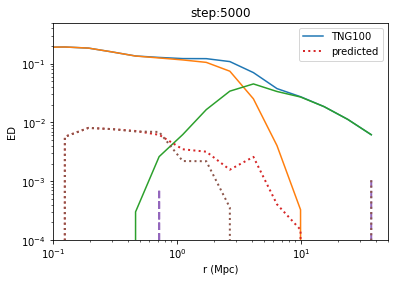

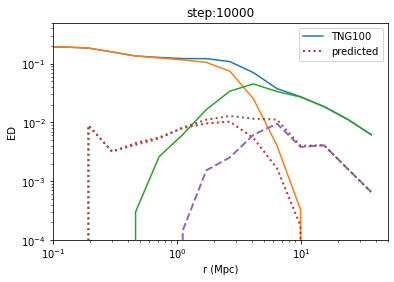

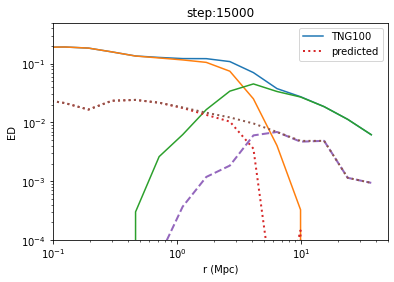

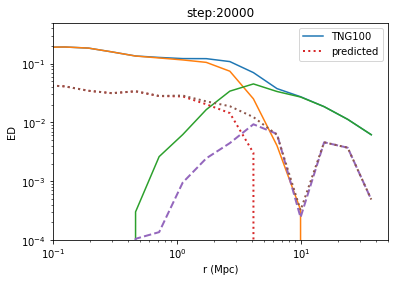

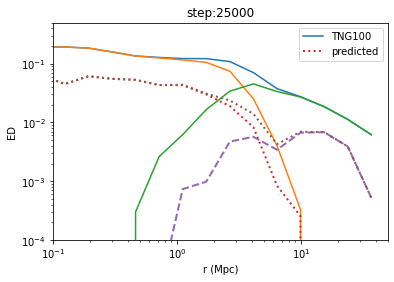

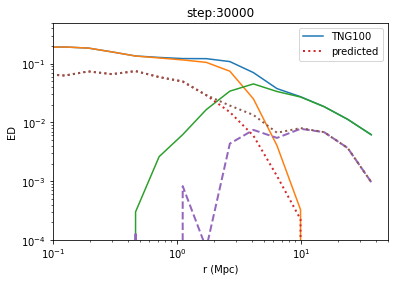

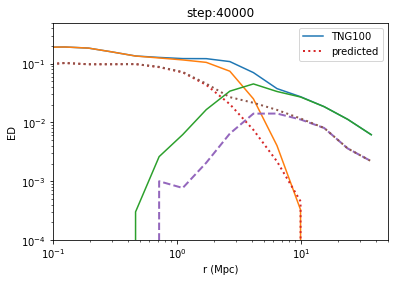

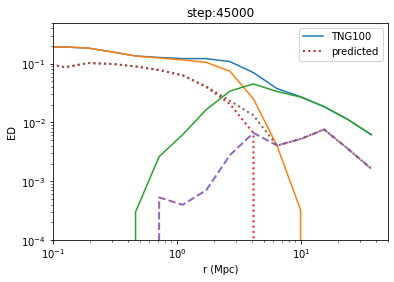

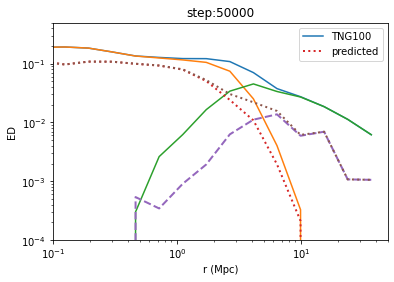

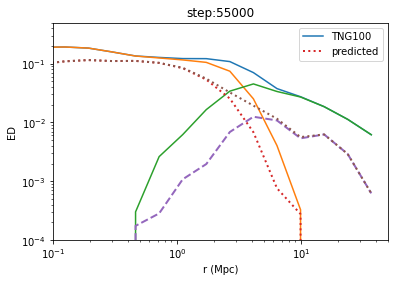

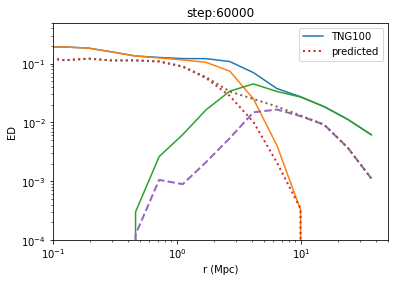

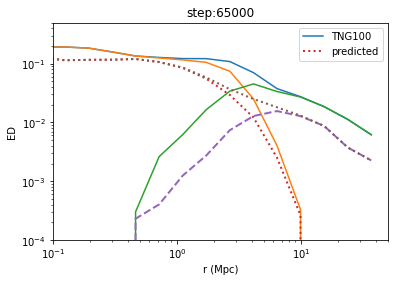

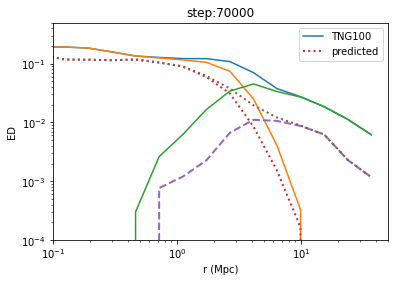

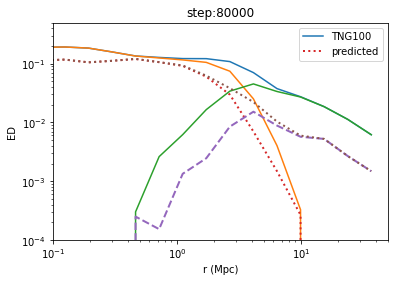

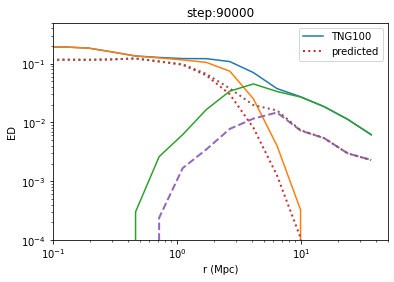

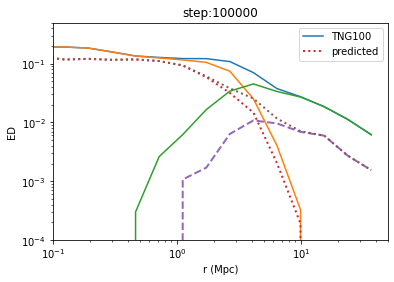

In [80]:
steps=[5000,10000,15000,20000,25000,30000,40000,45000,50000,55000,60000,65000,70000,80000,90000,100000]
for step in steps:    
    gen = gan_estimator.predict(testing_fn, checkpoint_path = './scale_multi_Nmesh_1024_MLP/model.ckpt-'+str(step) ,yield_single_examples=False)
    #gen = gan_estimator.predict(testing_fn,yield_single_examples=False)
    toto = concatenate([g for g in gen])
    cat = Table(toto, names=['shapesDMs.a3d_x', 'shapesDMs.a3d_y', 'shapesDMs.a3d_z'])
    cat['gal_id'] = catalog['gal_id']
    from astropy.table import join
    res = join(cat,catalog)
    rbins = np.logspace(-1.5,1.35,16)

    pos = np.array([res['gal_pos_x'], res['gal_pos_y'], res['gal_pos_z']]).T
    or1 = np.array([res['dm_av_x'], res['dm_av_y'], res['dm_av_z']]).T 
    or2 = np.array([res['shapesDMs.a3d_x'], res['shapesDMs.a3d_y'], res['shapesDMs.a3d_z']]).T 
    gid = np.squeeze(np.array([res['GroupID']]))
    group_distance = 75
    mpos = (res['central_bool'] >-1)# & (res['group_x'] < group_distance)& (res['group_y'] < group_distance)& (res['group_z'] < group_distance)
    mor  = (res['central_bool'] >-1) 
    m = (res['central_bool'] >-1) 
    # Adds a mass cut& (res['group_x'] < 25)& (res['group_x'] < 25)
    #m = (res['mass'] > 9) & (res['group_x'] < group_distance)& (res['group_y'] < group_distance)& (res['group_z'] < group_distance)
    ed1h,ed2h = ed_3d_one_two_halo_decomp(pos[mor & m], or1[mor & m], gid[mor & m],  pos[mpos], gid[mpos], rbins, period=75, num_threads=28)
    ed1h2,ed2h2 = ed_3d_one_two_halo_decomp(pos[mor & m], or2[mor & m], gid[mor & m],  pos[mpos], gid[mpos], rbins, period=75, num_threads=28)
    # Without mass cut all-all
    plt.figure()
    plot(rbins[1:] + rbins[:-1], ed1h+ed2h,label='TNG100')
    plot(rbins[1:] + rbins[:-1], ed1h)
    plot(rbins[1:] + rbins[:-1], ed2h)

    plot(rbins[1:] + rbins[:-1], ed1h2,':',label='predicted',lw=2)
    plot(rbins[1:] + rbins[:-1], ed2h2,'--',lw=2)
    plot(rbins[1:] + rbins[:-1], ed1h2+ed2h2,':',lw=2)
    ylim(0.0001, 0.5)
    legend()
    title('step:' +str(step))
    ylabel('ED')
    xlabel('r (Mpc)')
    xscale('log')
    yscale('log')
    xlim(0.1,50)
    #try diffreent training epochs
    #try diffrent smoothing scales
    # try by mass bbins to see if the two halo term is affected
    
    
    #plot it just for centrals

In [ ]:
steps=[20000,25000,30000,35000,40000,45000,50000,55000,60000,65000]
for step in steps:    
    gen = gan_estimator.predict(testing_fn, checkpoint_path = './scale_0.1_Nmesh_1024/model.ckpt-'+str(step) ,yield_single_examples=False)
    #gen = gan_estimator.predict(testing_fn,yield_single_examples=False)
    toto = concatenate([g for g in gen])
    cat = Table(toto, names=['shapesDMs.a3d_x', 'shapesDMs.a3d_y', 'shapesDMs.a3d_z'])
    cat['gal_id'] = catalog['gal_id']
    from astropy.table import join
    res = join(cat,catalog)
    rbins = np.logspace(-1.5,1.5,16)

    pos = np.array([res['gal_pos_x'], res['gal_pos_y'], res['gal_pos_z']]).T
    or1 = np.array([res['dm_av_x'], res['dm_av_y'], res['dm_av_z']]).T 
    or2 = np.array([res['shapesDMs.a3d_x'], res['shapesDMs.a3d_y'], res['shapesDMs.a3d_z']]).T 
    gid = np.squeeze(np.array([res['GroupID']]))
    group_distance = 50
    mpos = (res['central_bool'] >-1) & (res['group_x'] < group_distance)& (res['group_y'] < group_distance)& (res['group_z'] < group_distance)
    mor  = (res['central_bool'] >-1) 

    # Adds a mass cut& (res['group_x'] < 25)& (res['group_x'] < 25)
    m = (res['mass'] > 9) & (res['group_x'] < group_distance)& (res['group_y'] < group_distance)& (res['group_z'] < group_distance)
    ed1h,ed2h = ed_3d_one_two_halo_decomp(pos[mor & m], or1[mor & m], gid[mor & m],  pos[mpos], gid[mpos], rbins, period=None, num_threads=28)
    ed1h2,ed2h2 = ed_3d_one_two_halo_decomp(pos[mor & m], or2[mor & m], gid[mor & m],  pos[mpos], gid[mpos], rbins, period=None, num_threads=28)
    # Without mass cut all-all
    plt.figure()
    plot(rbins[1:] + rbins[:-1], ed1h+ed2h,label='TNG100')
    plot(rbins[1:] + rbins[:-1], ed1h)
    plot(rbins[1:] + rbins[:-1], ed2h)

    plot(rbins[1:] + rbins[:-1], ed1h2,':',label='predicted',lw=2)
    plot(rbins[1:] + rbins[:-1], ed2h2,'--',lw=2)
    plot(rbins[1:] + rbins[:-1], ed1h2+ed2h2,':',lw=2)
    ylim(0.0001, 0.5)
    legend()
    title('step:' +str(step))
    ylabel('ED')
    xlabel('r (Mpc)')
    xscale('log')
    yscale('log')
    xlim(0.1,50)
    #try diffreent training epochs
    #try diffrent smoothing scales
    # try by mass bbins to see if the two halo term is affected

In [ ]:
toto = concatenate([g for g in gen])

In [ ]:
# Without mass cut all-all
plot(rbins[1:] + rbins[:-1], ed1h+ed2h,label='TNG100')
plot(rbins[1:] + rbins[:-1], ed1h)
plot(rbins[1:] + rbins[:-1], ed2h)

plot(rbins[1:] + rbins[:-1], ed1h2,':',label='predicted',lw=2)
plot(rbins[1:] + rbins[:-1], ed2h2,'--',lw=2)
plot(rbins[1:] + rbins[:-1], ed1h2+ed2h2,':',lw=2)
ylim(0.0001, 0.5)
legend()
ylabel('ED')
xlabel('r (Mpc)')
xscale('log')
yscale('log')
xlim(0.1,50)
#try diffreent training epochs
#try diffrent smoothing scales
# try by mass bbins to see if the two halo term is affected

In [ ]:
res

In [ ]:
m = res['central_bool'] == 1
hist(abs(res['shapesDMs.a3d_x']*res['dm_av_x'] +res['shapesDMs.a3d_y']*res['dm_av_y'] +  res['shapesDMs.a3d_z']*res['dm_av_z'])[m],100, alpha=0.5,density=True);
m = res['central_bool'] == 0
hist(abs(res['shapesDMs.a3d_x']*res['dm_av_x'] +res['shapesDMs.a3d_y']*res['dm_av_y'] +  res['shapesDMs.a3d_z']*res['dm_av_z'])[m],100, alpha=0.5, density=True);

In [ ]:
m = res['central_bool'] == 1
hist(abs(res['shapesDMs.a3d_x']*res['cen_x'] +res['shapesDMs.a3d_y']*res['cen_y'] +  res['shapesDMs.a3d_z']*res['cen_z'])[m],100, alpha=0.5,density=True);
m = res['central_bool'] == 0
hist(abs(res['shapesDMs.a3d_x']*res['cen_x'] +res['shapesDMs.a3d_y']*res['cen_y'] +  res['shapesDMs.a3d_z']*res['cen_z'])[m],100, alpha=0.5,density=True);

In [ ]:
m = res['central_bool'] == 1
hist(abs(res['tid_cv_x']*res['dm_av_x'] +res['dm_av_y']*res['tid_cv_y'] +  res['dm_av_z']*res['tid_cv_z'])[m],100, alpha=0.5,density=True);
m = res['central_bool'] == 1
hist(abs(res['tid_cv_x']*res['shapesDMs.a3d_x'] +res['shapesDMs.a3d_y']*res['tid_cv_y'] +  res['shapesDMs.a3d_z']*res['tid_cv_z'])[m],100, alpha=0.5,density=True);

In [ ]:
m = res['central_bool'] == 0
hist(abs(res['tid_cv_x']*res['dm_av_x'] +res['dm_av_y']*res['tid_cv_y'] +  res['dm_av_z']*res['tid_cv_z'])[m],100, alpha=0.5,density=True);
m = res['central_bool'] == 0
hist(abs(res['tid_cv_x']*res['shapesDMs.a3d_x'] +res['shapesDMs.a3d_y']*res['tid_cv_y'] +  res['shapesDMs.a3d_z']*res['tid_cv_z'])[m],100, alpha=0.5,density=True);

In [ ]:
m = res['central_bool'] == 0
hist((res['tid_av_x']*res['dm_av_x'] +res['dm_av_y']*res['tid_av_y'] +  res['dm_av_z']*res['tid_av_z'])[m],100, alpha=0.5,density=True);
m = res['central_bool'] == 1
hist((res['tid_av_x']*res['shapesDMs.a3d_x'] +res['shapesDMs.a3d_y']*res['tid_av_y'] +  res['shapesDMs.a3d_z']*res['tid_av_z'])[m],100, alpha=0.5,density=True);

In [ ]:
# Without mass cut sat-sat
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

In [ ]:
# Without mass cut cent-sat
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

In [ ]:
# Without mass cut all-all
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

In [ ]:
# Without mass cut all-all
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.1,50)

In [ ]:
# Without mass cut all-all
loglog(rbins[1:] + rbins[:-1], ed1h+ed2h)
loglog(rbins[1:] + rbins[:-1], ed1h)
loglog(rbins[1:] + rbins[:-1], ed2h)

loglog(rbins[1:] + rbins[:-1], ed1h2,'--')
loglog(rbins[1:] + rbins[:-1], ed2h2,'--')
loglog(rbins[1:] + rbins[:-1], ed1h2+ed2h2,'--')
ylim(0.0001, 0.5)
xlim(0.06,200)